# Credit Card Fraud Detection

## What is Credit Card Fraud?
Credit card fraud is when someone uses another person's credit card or account information to make unauthorized purchases or access funds through cash advances. Credit card fraud doesn’t just happen online; it happens in brick-and-mortar stores, too. As a business owner, you can avoid serious headaches – and unwanted publicity – by recognizing potentially fraudulent use of credit cards in your payment environment.

## Three challenges surrounding credit card fraud

1. It's not always easy to agree on ground truth for what "fraud" means.
2. Regardless of how you define ground truth, the vast majority of charges are not fraudulent.
3. Most merchants aren't experts at evaluating the business impact of fraud.

## Problem Statement:

The Credit Card Fraud Detection Problem includes modeling past credit card transactions with the knowledge of the ones that turned out to be a fraud. This model is then used to identify whether a new transaction is fraudulent or not. Our aim here is to detect 100% of the fraudulent transactions while minimizing the incorrect fraud classifications.


## Observations
- Very few transactions are actually fraudulent (less than 1%). The data set is highly skewed, consisting of `492` frauds in a total of `284,807` observations. This resulted in only `0.172%` fraud cases. This skewed set is justified by the low number of fraudulent transactions.
- The dataset consists of numerical values from the `28` ‘Principal Component Analysis (PCA)’ transformed features, namely V1 to V28. Furthermore, there is no metadata about the original features provided, so pre-analysis or feature study could not be done.
- The ‘Time’ and ‘Amount’ features are not transformed data.
- There is no missing value in the dataset.

## Why does class imbalanced affect model performance?

- In general, we want to maximize the recall while capping FPR (False Positive Rate), but you can classify a lot of charges wrong and still maintain a low FPR because you have a large number of true negatives.
- This is conducive to picking a relatively low threshold, which results in the high recall but extremely low precision.

## What is the catch?
- Training a model on a balanced dataset optimizes performance on validation data.
- However, the goal is to optimize performance on the imbalanced production dataset. You ultimately need to find a balance that works best in production.
- One solution to this problem is: Use all fraudulent transactions, but subsample non-fraudulent transactions as needed to hit our target rate.

## Business questions to brainstorm:
Since all features are anonymous, we will focus our analysis on non-anonymized features: `Time`, `Amount`
1. How different is the amount of money used in different transaction classes?
2. Do fraudulent transactions occur more often during a certain frames?


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_style("whitegrid")

In [2]:
data = pd.read_csv("Data/creditcard.csv")
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [4]:
pd.set_option("display.float", "{:.2f}".format)
data.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,...,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00
mean,94813.86,0.00,0.00,-0.00,0.00,0.00,0.00,-0.00,0.00,-0.00,...,0.00,-0.00,0.00,0.00,0.00,0.00,-0.00,-0.00,88.35,0.00
std,47488.15,1.96,1.65,1.52,1.42,1.38,1.33,1.24,1.19,1.10,...,0.73,0.73,0.62,0.61,0.52,0.48,0.40,0.33,250.12,0.04
min,0.00,-56.41,-72.72,-48.33,-5.68,-113.74,-26.16,-43.56,-73.22,-13.43,...,-34.83,-10.93,-44.81,-2.84,-10.30,-2.60,-22.57,-15.43,0.00,0.00
25%,54201.50,-0.92,-0.60,-0.89,-0.85,-0.69,-0.77,-0.55,-0.21,-0.64,...,-0.23,-0.54,-0.16,-0.35,-0.32,-0.33,-0.07,-0.05,5.60,0.00
50%,84692.00,0.02,0.07,0.18,-0.02,-0.05,-0.27,0.04,0.02,-0.05,...,-0.03,0.01,-0.01,0.04,0.02,-0.05,0.00,0.01,22.00,0.00
75%,139320.50,1.32,0.80,1.03,0.74,0.61,0.40,0.57,0.33,0.60,...,0.19,0.53,0.15,0.44,0.35,0.24,0.09,0.08,77.16,0.00
max,172792.00,2.45,22.06,9.38,16.88,34.80,73.30,120.59,20.01,15.59,...,27.20,10.50,22.53,4.58,7.52,3.52,31.61,33.85,25691.16,1.00


Let us now check the missing values in the dataset

In [5]:
data.isnull().sum().sum()

0

In [6]:
data.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

### The only non-transformed variables to work with are:
- `Time`
- `Amount`
- `Class` (1: fraud, 0: not_fraud)

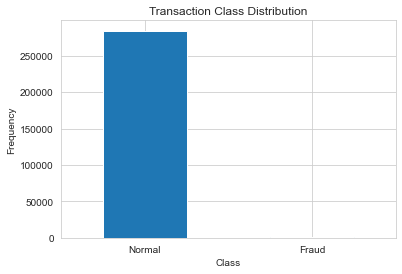

In [7]:
LABELS = ["Normal", "Fraud"]

count_classes = pd.value_counts(data['Class'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Transaction Class Distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency");

In [8]:
data.Class.value_counts()

0    284315
1       492
Name: Class, dtype: int64

Notice how imbalanced is our original dataset! Most of the transactions are non-fraud. If we use this dataframe as the base for our predictive models and analysis we might get a lot of errors and our algorithms will probably overfit since it will "assume" that most transactions are not fraud. But we don't want our model to assume, we want our model to detect patterns that give signs of fraud!

Determine the number of fraud and valid transactions in the entire dataset.


In [10]:
fraud = data[data['Class']==1]
normal = data[data['Class']==0]

print(f"Shape of Fraudulant transactions: {fraud.shape}")
print(f"Shape of Non-Fraudulant transactions: {normal.shape}")

Shape of Fraudulant transactions: (492, 31)
Shape of Non-Fraudulant transactions: (284315, 31)


How different are the amount of money used in different transaction classes?


In [11]:
pd.concat([fraud.Amount.describe(), normal.Amount.describe()], axis=1)

,Amount,Amount
count,492.00,284315.00
mean,122.21,88.29
std,256.68,250.11
min,0.00,0.00
25%,1.00,5.65
50%,9.25,22.00
75%,105.89,77.05
max,2125.87,25691.16


Do fraudulent transactions occur more often during certain time frame ?


In [12]:
pd.concat([fraud.Time.describe(), normal.Time.describe()], axis=1)

,Time,Time
count,492.00,284315.00
mean,80746.81,94838.20
std,47835.37,47484.02
min,406.00,0.00
25%,41241.50,54230.00
50%,75568.50,84711.00
75%,128483.00,139333.00
max,170348.00,172792.00


C:\Users\milad\Documents\Flatiron\Anaconda\envs\learn-env\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\milad\Documents\Flatiron\Anaconda\envs\learn-env\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


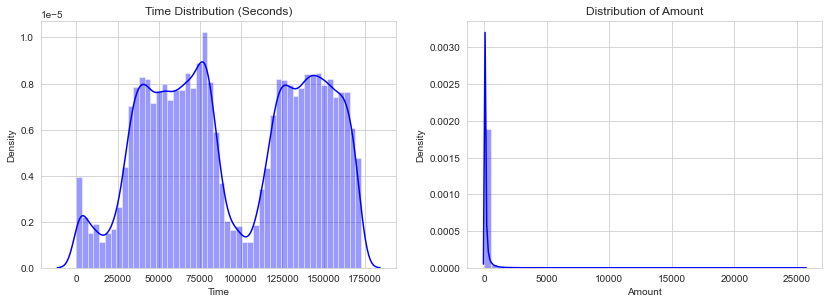

In [13]:
# plot the time feature
plt.figure(figsize=(14,10))

plt.subplot(2, 2, 1)
plt.title('Time Distribution (Seconds)')

sns.distplot(data['Time'], color='blue');

#plot the amount feature
plt.subplot(2, 2, 2)
plt.title('Distribution of Amount')
sns.distplot(data['Amount'],color='blue');

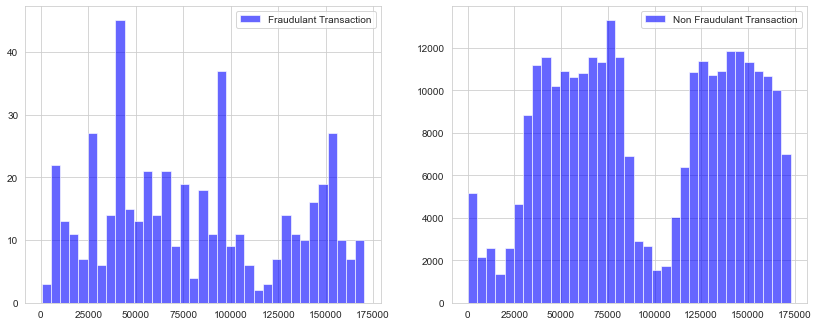

In [15]:
# data[data.Class == 0].Time.hist(bins=35, color='blue', alpha=0.6)
plt.figure(figsize=(14, 12))

plt.subplot(2, 2, 1)
data[data.Class == 1].Time.hist(bins=35, color='blue', alpha=0.6, label="Fraudulant Transaction")
plt.legend()

plt.subplot(2, 2, 2)
data[data.Class == 0].Time.hist(bins=35, color='blue', alpha=0.6, label="Non Fraudulant Transaction")
plt.legend();

By seeing the distributions we can have an idea how skewed are these features, we can also see further distributions of the other features. There are techniques that can help the distributions be less skewed which will be implemented in this notebook in the future.

Doesn't seem like the time of transaction really matters here as per above observation.
Now let us take a sample of the dataset for out modelling and prediction

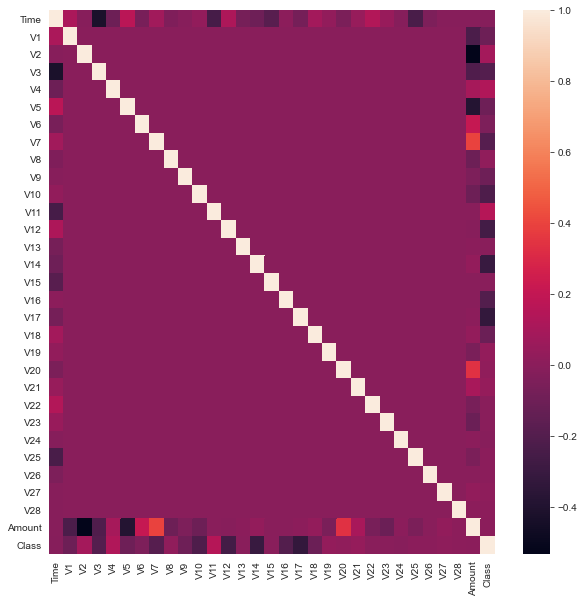

In [17]:
# heatmap to find any high correlations

plt.figure(figsize=(10,10))
sns.heatmap(data=data.corr())
plt.show();

### Highest correlations come from:
    - Time & V3 (-0.42)
    - Amount & V2 (-0.53)
    - Amount & V4 (0.4)
    
- While these correlations are high, I don't expect it to run the risk of multicollinearity.

- The correlation matrix shows also that none of the V1 to V28 PCA components have any correlation to each other however if we observe Class has some form positive and negative correlations with the V components but has no correlation with Time and Amount.

# 3. Data Pre-processing

`Time` and `Amount` should be scaled as the other columns.


In [19]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

scalar = StandardScaler()

X = data.drop('Class', axis=1)
y = data.Class

X_train_v, X_test, y_train_v, y_test = train_test_split(X, y, 
                                                    test_size=0.3, random_state=42)
X_train, X_validate, y_train, y_validate = train_test_split(X_train_v, y_train_v, 
                                                            test_size=0.2, random_state=42)

X_train = scalar.fit_transform(X_train)
X_validate = scalar.transform(X_validate)
X_test = scalar.transform(X_test)

w_p = y_train.value_counts()[0] / len(y_train)
w_n = y_train.value_counts()[1] / len(y_train)

print(f"Fraudulant transaction weight: {w_n}")
print(f"Non-Fraudulant transaction weight: {w_p}")

Fraudulant transaction weight: 0.0017994745785028623
Non-Fraudulant transaction weight: 0.9982005254214972


In [20]:
print(f"TRAINING: X_train: {X_train.shape}, y_train: {y_train.shape}\n{'_'*55}")
print(f"VALIDATION: X_validate: {X_validate.shape}, y_validate: {y_validate.shape}\n{'_'*50}")
print(f"TESTING: X_test: {X_test.shape}, y_test: {y_test.shape}")

TRAINING: X_train: (159491, 30), y_train: (159491,)
_______________________________________________________
VALIDATION: X_validate: (39873, 30), y_validate: (39873,)
__________________________________________________
TESTING: X_test: (85443, 30), y_test: (85443,)


In [21]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score

def print_score(label, prediction, train=True):
    if train:
        clf_report = pd.DataFrame(classification_report(label, prediction, output_dict=True))
        print("Train Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(label, prediction) * 100:.2f}%")
        print("_______________________________________________")
        print(f"Classification Report:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_train, prediction)}\n")
        
    elif train==False:
        clf_report = pd.DataFrame(classification_report(label, prediction, output_dict=True))
        print("Test Result:\n================================================")        
        print(f"Accuracy Score: {accuracy_score(label, prediction) * 100:.2f}%")
        print("_______________________________________________")
        print(f"Classification Report:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(label, prediction)}\n") 

# 4. Model Building
# 4. 1. Artificial Neural Network (ANNs)

In [22]:
from tensorflow import keras

model = keras.Sequential([
    keras.layers.Dense(256, activation='relu', input_shape=(X_train.shape[-1],)),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(1, activation='sigmoid'),
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               7936      
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               6

In [23]:
METRICS = [
#     keras.metrics.Accuracy(name='accuracy'),
    keras.metrics.FalseNegatives(name='fn'),
    keras.metrics.FalsePositives(name='fp'),
    keras.metrics.TrueNegatives(name='tn'),
    keras.metrics.TruePositives(name='tp'),
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall')
]

model.compile(optimizer=keras.optimizers.Adam(1e-4), loss='binary_crossentropy', metrics=METRICS)

callbacks = [keras.callbacks.ModelCheckpoint('fraud_model_at_epoch_{epoch}.h5')]
class_weight = {0:w_p, 1:w_n}

r = model.fit(
    X_train, y_train, 
    validation_data=(X_validate, y_validate),
    batch_size=2048, 
    epochs=300, 
#     class_weight=class_weight,
    callbacks=callbacks,
)

Epoch 1/300
78/78 [==============================] - 3s 43ms/step - loss: 0.8062 - fn: 53.0000 - fp: 73375.0000 - tn: 85829.0000 - tp: 234.0000 - precision: 0.0032 - recall: 0.8153 - val_loss: 0.5895 - val_fn: 12.0000 - val_fp: 1145.0000 - val_tn: 38659.0000 - val_tp: 57.0000 - val_precision: 0.0474 - val_recall: 0.8261
Epoch 2/300
78/78 [==============================] - 3s 37ms/step - loss: 0.6873 - fn: 46.0000 - fp: 60829.0000 - tn: 98375.0000 - tp: 241.0000 - precision: 0.0039 - recall: 0.8397 - val_loss: 0.5439 - val_fn: 12.0000 - val_fp: 522.0000 - val_tn: 39282.0000 - val_tp: 57.0000 - val_precision: 0.0984 - val_recall: 0.8261
Epoch 3/300
78/78 [==============================] - 3s 36ms/step - loss: 0.6095 - fn: 48.0000 - fp: 47940.0000 - tn: 111264.0000 - tp: 239.0000 - precision: 0.0050 - recall: 0.8328 - val_loss: 0.4751 - val_fn: 12.0000 - val_fp: 168.0000 - val_tn: 39636.0000 - val_tp: 57.0000 - val_precision: 0.2533 - val_recall: 0.8261
Epoch 4/300
78/78 [================

Epoch 27/300
78/78 [==============================] - 3s 35ms/step - loss: 0.0289 - fn: 103.0000 - fp: 96.0000 - tn: 159108.0000 - tp: 184.0000 - precision: 0.6571 - recall: 0.6411 - val_loss: 0.0259 - val_fn: 14.0000 - val_fp: 14.0000 - val_tn: 39790.0000 - val_tp: 55.0000 - val_precision: 0.7971 - val_recall: 0.7971
Epoch 28/300
78/78 [==============================] - 3s 35ms/step - loss: 0.0284 - fn: 92.0000 - fp: 114.0000 - tn: 159090.0000 - tp: 195.0000 - precision: 0.6311 - recall: 0.6794 - val_loss: 0.0221 - val_fn: 14.0000 - val_fp: 14.0000 - val_tn: 39790.0000 - val_tp: 55.0000 - val_precision: 0.7971 - val_recall: 0.7971
Epoch 29/300
78/78 [==============================] - 3s 34ms/step - loss: 0.0260 - fn: 94.0000 - fp: 89.0000 - tn: 159115.0000 - tp: 193.0000 - precision: 0.6844 - recall: 0.6725 - val_loss: 0.0193 - val_fn: 14.0000 - val_fp: 14.0000 - val_tn: 39790.0000 - val_tp: 55.0000 - val_precision: 0.7971 - val_recall: 0.7971
Epoch 30/300
78/78 [=====================

Epoch 53/300
78/78 [==============================] - 3s 35ms/step - loss: 0.0103 - fn: 91.0000 - fp: 52.0000 - tn: 159152.0000 - tp: 196.0000 - precision: 0.7903 - recall: 0.6829 - val_loss: 0.0095 - val_fn: 13.0000 - val_fp: 13.0000 - val_tn: 39791.0000 - val_tp: 56.0000 - val_precision: 0.8116 - val_recall: 0.8116
Epoch 54/300
78/78 [==============================] - 3s 36ms/step - loss: 0.0089 - fn: 87.0000 - fp: 38.0000 - tn: 159166.0000 - tp: 200.0000 - precision: 0.8403 - recall: 0.6969 - val_loss: 0.0081 - val_fn: 13.0000 - val_fp: 12.0000 - val_tn: 39792.0000 - val_tp: 56.0000 - val_precision: 0.8235 - val_recall: 0.8116
Epoch 55/300
78/78 [==============================] - 3s 35ms/step - loss: 0.0105 - fn: 95.0000 - fp: 49.0000 - tn: 159155.0000 - tp: 192.0000 - precision: 0.7967 - recall: 0.6690 - val_loss: 0.0087 - val_fn: 13.0000 - val_fp: 13.0000 - val_tn: 39791.0000 - val_tp: 56.0000 - val_precision: 0.8116 - val_recall: 0.8116
Epoch 56/300
78/78 [=======================

Epoch 79/300
78/78 [==============================] - 3s 35ms/step - loss: 0.0051 - fn: 83.0000 - fp: 29.0000 - tn: 159175.0000 - tp: 204.0000 - precision: 0.8755 - recall: 0.7108 - val_loss: 0.0055 - val_fn: 16.0000 - val_fp: 9.0000 - val_tn: 39795.0000 - val_tp: 53.0000 - val_precision: 0.8548 - val_recall: 0.7681
Epoch 80/300
78/78 [==============================] - 3s 35ms/step - loss: 0.0051 - fn: 91.0000 - fp: 25.0000 - tn: 159179.0000 - tp: 196.0000 - precision: 0.8869 - recall: 0.6829 - val_loss: 0.0054 - val_fn: 16.0000 - val_fp: 9.0000 - val_tn: 39795.0000 - val_tp: 53.0000 - val_precision: 0.8548 - val_recall: 0.7681
Epoch 81/300
78/78 [==============================] - 3s 36ms/step - loss: 0.0045 - fn: 78.0000 - fp: 27.0000 - tn: 159177.0000 - tp: 209.0000 - precision: 0.8856 - recall: 0.7282 - val_loss: 0.0055 - val_fn: 16.0000 - val_fp: 9.0000 - val_tn: 39795.0000 - val_tp: 53.0000 - val_precision: 0.8548 - val_recall: 0.7681
Epoch 82/300
78/78 [==========================

Epoch 105/300
78/78 [==============================] - 3s 35ms/step - loss: 0.0033 - fn: 70.0000 - fp: 23.0000 - tn: 159181.0000 - tp: 217.0000 - precision: 0.9042 - recall: 0.7561 - val_loss: 0.0048 - val_fn: 16.0000 - val_fp: 8.0000 - val_tn: 39796.0000 - val_tp: 53.0000 - val_precision: 0.8689 - val_recall: 0.7681
Epoch 106/300
78/78 [==============================] - 3s 35ms/step - loss: 0.0032 - fn: 75.0000 - fp: 22.0000 - tn: 159182.0000 - tp: 212.0000 - precision: 0.9060 - recall: 0.7387 - val_loss: 0.0048 - val_fn: 16.0000 - val_fp: 8.0000 - val_tn: 39796.0000 - val_tp: 53.0000 - val_precision: 0.8689 - val_recall: 0.7681
Epoch 107/300
78/78 [==============================] - 3s 36ms/step - loss: 0.0035 - fn: 86.0000 - fp: 24.0000 - tn: 159180.0000 - tp: 201.0000 - precision: 0.8933 - recall: 0.7003 - val_loss: 0.0047 - val_fn: 16.0000 - val_fp: 8.0000 - val_tn: 39796.0000 - val_tp: 53.0000 - val_precision: 0.8689 - val_recall: 0.7681
Epoch 108/300
78/78 [======================

Epoch 131/300
78/78 [==============================] - 3s 35ms/step - loss: 0.0023 - fn: 60.0000 - fp: 15.0000 - tn: 159189.0000 - tp: 227.0000 - precision: 0.9380 - recall: 0.7909 - val_loss: 0.0043 - val_fn: 16.0000 - val_fp: 7.0000 - val_tn: 39797.0000 - val_tp: 53.0000 - val_precision: 0.8833 - val_recall: 0.7681
Epoch 132/300
78/78 [==============================] - 3s 35ms/step - loss: 0.0024 - fn: 60.0000 - fp: 14.0000 - tn: 159190.0000 - tp: 227.0000 - precision: 0.9419 - recall: 0.7909 - val_loss: 0.0042 - val_fn: 17.0000 - val_fp: 6.0000 - val_tn: 39798.0000 - val_tp: 52.0000 - val_precision: 0.8966 - val_recall: 0.7536
Epoch 133/300
78/78 [==============================] - 3s 39ms/step - loss: 0.0023 - fn: 70.0000 - fp: 17.0000 - tn: 159187.0000 - tp: 217.0000 - precision: 0.9274 - recall: 0.7561 - val_loss: 0.0044 - val_fn: 16.0000 - val_fp: 6.0000 - val_tn: 39798.0000 - val_tp: 53.0000 - val_precision: 0.8983 - val_recall: 0.7681
Epoch 134/300
78/78 [======================

Epoch 157/300
78/78 [==============================] - 3s 36ms/step - loss: 0.0019 - fn: 48.0000 - fp: 19.0000 - tn: 159185.0000 - tp: 239.0000 - precision: 0.9264 - recall: 0.8328 - val_loss: 0.0047 - val_fn: 16.0000 - val_fp: 7.0000 - val_tn: 39797.0000 - val_tp: 53.0000 - val_precision: 0.8833 - val_recall: 0.7681
Epoch 158/300
78/78 [==============================] - 3s 36ms/step - loss: 0.0019 - fn: 58.0000 - fp: 12.0000 - tn: 159192.0000 - tp: 229.0000 - precision: 0.9502 - recall: 0.7979 - val_loss: 0.0048 - val_fn: 16.0000 - val_fp: 6.0000 - val_tn: 39798.0000 - val_tp: 53.0000 - val_precision: 0.8983 - val_recall: 0.7681
Epoch 159/300
78/78 [==============================] - 3s 35ms/step - loss: 0.0021 - fn: 58.0000 - fp: 21.0000 - tn: 159183.0000 - tp: 229.0000 - precision: 0.9160 - recall: 0.7979 - val_loss: 0.0048 - val_fn: 16.0000 - val_fp: 7.0000 - val_tn: 39797.0000 - val_tp: 53.0000 - val_precision: 0.8833 - val_recall: 0.7681
Epoch 160/300
78/78 [======================

Epoch 183/300
78/78 [==============================] - 3s 35ms/step - loss: 0.0016 - fn: 45.0000 - fp: 19.0000 - tn: 159185.0000 - tp: 242.0000 - precision: 0.9272 - recall: 0.8432 - val_loss: 0.0048 - val_fn: 16.0000 - val_fp: 6.0000 - val_tn: 39798.0000 - val_tp: 53.0000 - val_precision: 0.8983 - val_recall: 0.7681
Epoch 184/300
78/78 [==============================] - 3s 35ms/step - loss: 0.0015 - fn: 47.0000 - fp: 11.0000 - tn: 159193.0000 - tp: 240.0000 - precision: 0.9562 - recall: 0.8362 - val_loss: 0.0049 - val_fn: 15.0000 - val_fp: 6.0000 - val_tn: 39798.0000 - val_tp: 54.0000 - val_precision: 0.9000 - val_recall: 0.7826
Epoch 185/300
78/78 [==============================] - 3s 35ms/step - loss: 0.0017 - fn: 54.0000 - fp: 16.0000 - tn: 159188.0000 - tp: 233.0000 - precision: 0.9357 - recall: 0.8118 - val_loss: 0.0049 - val_fn: 15.0000 - val_fp: 6.0000 - val_tn: 39798.0000 - val_tp: 54.0000 - val_precision: 0.9000 - val_recall: 0.7826
Epoch 186/300
78/78 [======================

Epoch 209/300
78/78 [==============================] - 3s 37ms/step - loss: 0.0013 - fn: 41.0000 - fp: 11.0000 - tn: 159193.0000 - tp: 246.0000 - precision: 0.9572 - recall: 0.8571 - val_loss: 0.0051 - val_fn: 15.0000 - val_fp: 4.0000 - val_tn: 39800.0000 - val_tp: 54.0000 - val_precision: 0.9310 - val_recall: 0.7826
Epoch 210/300
78/78 [==============================] - 3s 36ms/step - loss: 0.0015 - fn: 48.0000 - fp: 8.0000 - tn: 159196.0000 - tp: 239.0000 - precision: 0.9676 - recall: 0.8328 - val_loss: 0.0052 - val_fn: 15.0000 - val_fp: 4.0000 - val_tn: 39800.0000 - val_tp: 54.0000 - val_precision: 0.9310 - val_recall: 0.7826
Epoch 211/300
78/78 [==============================] - 3s 36ms/step - loss: 0.0014 - fn: 44.0000 - fp: 13.0000 - tn: 159191.0000 - tp: 243.0000 - precision: 0.9492 - recall: 0.8467 - val_loss: 0.0051 - val_fn: 15.0000 - val_fp: 4.0000 - val_tn: 39800.0000 - val_tp: 54.0000 - val_precision: 0.9310 - val_recall: 0.7826
Epoch 212/300
78/78 [=======================

Epoch 235/300
78/78 [==============================] - 3s 36ms/step - loss: 0.0013 - fn: 36.0000 - fp: 14.0000 - tn: 159190.0000 - tp: 251.0000 - precision: 0.9472 - recall: 0.8746 - val_loss: 0.0051 - val_fn: 15.0000 - val_fp: 4.0000 - val_tn: 39800.0000 - val_tp: 54.0000 - val_precision: 0.9310 - val_recall: 0.7826
Epoch 236/300
78/78 [==============================] - 3s 36ms/step - loss: 0.0011 - fn: 34.0000 - fp: 12.0000 - tn: 159192.0000 - tp: 253.0000 - precision: 0.9547 - recall: 0.8815 - val_loss: 0.0050 - val_fn: 15.0000 - val_fp: 3.0000 - val_tn: 39801.0000 - val_tp: 54.0000 - val_precision: 0.9474 - val_recall: 0.7826
Epoch 237/300
78/78 [==============================] - 3s 36ms/step - loss: 0.0011 - fn: 41.0000 - fp: 10.0000 - tn: 159194.0000 - tp: 246.0000 - precision: 0.9609 - recall: 0.8571 - val_loss: 0.0051 - val_fn: 15.0000 - val_fp: 3.0000 - val_tn: 39801.0000 - val_tp: 54.0000 - val_precision: 0.9474 - val_recall: 0.7826
Epoch 238/300
78/78 [======================

Epoch 261/300
78/78 [==============================] - 3s 36ms/step - loss: 0.0011 - fn: 35.0000 - fp: 10.0000 - tn: 159194.0000 - tp: 252.0000 - precision: 0.9618 - recall: 0.8780 - val_loss: 0.0057 - val_fn: 15.0000 - val_fp: 5.0000 - val_tn: 39799.0000 - val_tp: 54.0000 - val_precision: 0.9153 - val_recall: 0.7826
Epoch 262/300
78/78 [==============================] - 3s 36ms/step - loss: 0.0010 - fn: 32.0000 - fp: 14.0000 - tn: 159190.0000 - tp: 255.0000 - precision: 0.9480 - recall: 0.8885 - val_loss: 0.0055 - val_fn: 15.0000 - val_fp: 5.0000 - val_tn: 39799.0000 - val_tp: 54.0000 - val_precision: 0.9153 - val_recall: 0.7826
Epoch 263/300
78/78 [==============================] - 3s 36ms/step - loss: 0.0010 - fn: 39.0000 - fp: 10.0000 - tn: 159194.0000 - tp: 248.0000 - precision: 0.9612 - recall: 0.8641 - val_loss: 0.0056 - val_fn: 15.0000 - val_fp: 5.0000 - val_tn: 39799.0000 - val_tp: 54.0000 - val_precision: 0.9153 - val_recall: 0.7826
Epoch 264/300
78/78 [======================

78/78 [==============================] - 3s 36ms/step - loss: 7.9832e-04 - fn: 31.0000 - fp: 11.0000 - tn: 159193.0000 - tp: 256.0000 - precision: 0.9588 - recall: 0.8920 - val_loss: 0.0058 - val_fn: 15.0000 - val_fp: 4.0000 - val_tn: 39800.0000 - val_tp: 54.0000 - val_precision: 0.9310 - val_recall: 0.7826
Epoch 287/300
78/78 [==============================] - 3s 36ms/step - loss: 8.0971e-04 - fn: 30.0000 - fp: 12.0000 - tn: 159192.0000 - tp: 257.0000 - precision: 0.9554 - recall: 0.8955 - val_loss: 0.0058 - val_fn: 15.0000 - val_fp: 6.0000 - val_tn: 39798.0000 - val_tp: 54.0000 - val_precision: 0.9000 - val_recall: 0.7826
Epoch 288/300
78/78 [==============================] - 3s 35ms/step - loss: 9.4276e-04 - fn: 31.0000 - fp: 12.0000 - tn: 159192.0000 - tp: 256.0000 - precision: 0.9552 - recall: 0.8920 - val_loss: 0.0057 - val_fn: 15.0000 - val_fp: 6.0000 - val_tn: 39798.0000 - val_tp: 54.0000 - val_precision: 0.9000 - val_recall: 0.7826
Epoch 289/300
78/78 [========================

In [24]:
score = model.evaluate(X_test, y_test)
print(score)

2671/2671 [==============================] - 2s 701us/step - loss: 0.0038 - fn: 22.0000 - fp: 16.0000 - tn: 85291.0000 - tp: 114.0000 - precision: 0.8769 - recall: 0.8382
[0.003812228562310338, 22.0, 16.0, 85291.0, 114.0, 0.8769230842590332, 0.8382353186607361]


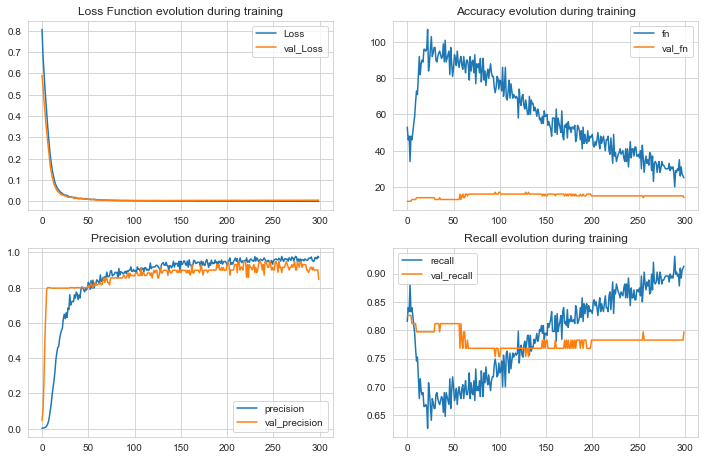

In [25]:
plt.figure(figsize=(12, 16))

plt.subplot(4, 2, 1)
plt.plot(r.history['loss'], label='Loss')
plt.plot(r.history['val_loss'], label='val_Loss')
plt.title('Loss Function evolution during training')
plt.legend()

plt.subplot(4, 2, 2)
plt.plot(r.history['fn'], label='fn')
plt.plot(r.history['val_fn'], label='val_fn')
plt.title('Accuracy evolution during training')
plt.legend()

plt.subplot(4, 2, 3)
plt.plot(r.history['precision'], label='precision')
plt.plot(r.history['val_precision'], label='val_precision')
plt.title('Precision evolution during training')
plt.legend()

plt.subplot(4, 2, 4)
plt.plot(r.history['recall'], label='recall')
plt.plot(r.history['val_recall'], label='val_recall')
plt.title('Recall evolution during training')
plt.legend()

In [26]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

print_score(y_train, y_train_pred.round(), train=True)
print_score(y_test, y_test_pred.round(), train=False)

scores_dict = {
    'ANNs': {
        'Train': f1_score(y_train, y_train_pred.round()),
        'Test': f1_score(y_test, y_test_pred.round()),
    },
}

Train Result:
Accuracy Score: 99.99%
_______________________________________________
Classification Report:
                  0      1  accuracy  macro avg  weighted avg
precision      1.00   0.98      1.00       0.99          1.00
recall         1.00   0.95      1.00       0.98          1.00
f1-score       1.00   0.96      1.00       0.98          1.00
support   159204.00 287.00      1.00  159491.00     159491.00
_______________________________________________
Confusion Matrix: 
 [[159197      7]
 [    13    274]]

Test Result:
Accuracy Score: 99.96%
_______________________________________________
Classification Report:
                 0      1  accuracy  macro avg  weighted avg
precision     1.00   0.88      1.00       0.94          1.00
recall        1.00   0.84      1.00       0.92          1.00
f1-score      1.00   0.86      1.00       0.93          1.00
support   85307.00 136.00      1.00   85443.00      85443.00
_______________________________________________
Confusion Matrix: 

# 4. 2. XGBoost

In [27]:
from xgboost import XGBClassifier

xgb_clf = XGBClassifier()
xgb_clf.fit(X_train, y_train, eval_metric='aucpr')

y_train_pred = xgb_clf.predict(X_train)
y_test_pred = xgb_clf.predict(X_test)

print_score(y_train, y_train_pred, train=True)
print_score(y_test, y_test_pred, train=False)

scores_dict['XGBoost'] = {
        'Train': f1_score(y_train,y_train_pred),
        'Test': f1_score(y_test, y_test_pred),
}

Train Result:
Accuracy Score: 100.00%
_______________________________________________
Classification Report:
                  0      1  accuracy  macro avg  weighted avg
precision      1.00   1.00      1.00       1.00          1.00
recall         1.00   1.00      1.00       1.00          1.00
f1-score       1.00   1.00      1.00       1.00          1.00
support   159204.00 287.00      1.00  159491.00     159491.00
_______________________________________________
Confusion Matrix: 
 [[159204      0]
 [     0    287]]

Test Result:
Accuracy Score: 99.96%
_______________________________________________
Classification Report:
                 0      1  accuracy  macro avg  weighted avg
precision     1.00   0.95      1.00       0.97          1.00
recall        1.00   0.82      1.00       0.91          1.00
f1-score      1.00   0.88      1.00       0.94          1.00
support   85307.00 136.00      1.00   85443.00      85443.00
_______________________________________________
Confusion Matrix:

# 4. 3. Random Forest

In [29]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(n_estimators=100, oob_score=False)
rf_clf.fit(X_train, y_train)

y_train_pred = rf_clf.predict(X_train)
y_test_pred = rf_clf.predict(X_test)

print_score(y_train, y_train_pred, train=True)
print_score(y_test, y_test_pred, train=False)

scores_dict['Random Forest'] = {
        'Train': f1_score(y_train,y_train_pred),
        'Test': f1_score(y_test, y_test_pred),
}

Train Result:
Accuracy Score: 100.00%
_______________________________________________
Classification Report:
                  0      1  accuracy  macro avg  weighted avg
precision      1.00   1.00      1.00       1.00          1.00
recall         1.00   1.00      1.00       1.00          1.00
f1-score       1.00   1.00      1.00       1.00          1.00
support   159204.00 287.00      1.00  159491.00     159491.00
_______________________________________________
Confusion Matrix: 
 [[159204      0]
 [     0    287]]

Test Result:
Accuracy Score: 99.96%
_______________________________________________
Classification Report:
                 0      1  accuracy  macro avg  weighted avg
precision     1.00   0.91      1.00       0.95          1.00
recall        1.00   0.81      1.00       0.90          1.00
f1-score      1.00   0.86      1.00       0.93          1.00
support   85307.00 136.00      1.00   85443.00      85443.00
_______________________________________________
Confusion Matrix:

# 4. 4. CatBoost

In [31]:
#!pip install catboost

In [32]:
from catboost import CatBoostClassifier

cb_clf = CatBoostClassifier()
cb_clf.fit(X_train, y_train)

Learning rate set to 0.089847
0:	learn: 0.3914646	total: 158ms	remaining: 2m 37s
1:	learn: 0.2368426	total: 176ms	remaining: 1m 27s
2:	learn: 0.1341781	total: 196ms	remaining: 1m 5s
3:	learn: 0.0788514	total: 214ms	remaining: 53.2s
4:	learn: 0.0482948	total: 231ms	remaining: 46s
5:	learn: 0.0315326	total: 249ms	remaining: 41.2s
6:	learn: 0.0213628	total: 267ms	remaining: 37.9s
7:	learn: 0.0153604	total: 284ms	remaining: 35.3s
8:	learn: 0.0115137	total: 302ms	remaining: 33.2s
9:	learn: 0.0090128	total: 318ms	remaining: 31.5s
10:	learn: 0.0071550	total: 336ms	remaining: 30.2s
11:	learn: 0.0060638	total: 353ms	remaining: 29.1s
12:	learn: 0.0052453	total: 371ms	remaining: 28.2s
13:	learn: 0.0046542	total: 388ms	remaining: 27.3s
14:	learn: 0.0042229	total: 405ms	remaining: 26.6s
15:	learn: 0.0038780	total: 423ms	remaining: 26s
16:	learn: 0.0036112	total: 440ms	remaining: 25.4s
17:	learn: 0.0034152	total: 457ms	remaining: 25s
18:	learn: 0.0032510	total: 474ms	remaining: 24.5s
19:	learn: 0.00

168:	learn: 0.0011997	total: 3.15s	remaining: 15.5s
169:	learn: 0.0011975	total: 3.17s	remaining: 15.5s
170:	learn: 0.0011950	total: 3.19s	remaining: 15.5s
171:	learn: 0.0011937	total: 3.2s	remaining: 15.4s
172:	learn: 0.0011858	total: 3.22s	remaining: 15.4s
173:	learn: 0.0011818	total: 3.24s	remaining: 15.4s
174:	learn: 0.0011801	total: 3.26s	remaining: 15.3s
175:	learn: 0.0011772	total: 3.27s	remaining: 15.3s
176:	learn: 0.0011728	total: 3.29s	remaining: 15.3s
177:	learn: 0.0011700	total: 3.31s	remaining: 15.3s
178:	learn: 0.0011608	total: 3.33s	remaining: 15.3s
179:	learn: 0.0011524	total: 3.35s	remaining: 15.2s
180:	learn: 0.0011503	total: 3.36s	remaining: 15.2s
181:	learn: 0.0011484	total: 3.38s	remaining: 15.2s
182:	learn: 0.0011466	total: 3.4s	remaining: 15.2s
183:	learn: 0.0011449	total: 3.41s	remaining: 15.1s
184:	learn: 0.0011423	total: 3.43s	remaining: 15.1s
185:	learn: 0.0011402	total: 3.45s	remaining: 15.1s
186:	learn: 0.0011347	total: 3.47s	remaining: 15.1s
187:	learn: 0.

337:	learn: 0.0007300	total: 6.17s	remaining: 12.1s
338:	learn: 0.0007283	total: 6.19s	remaining: 12.1s
339:	learn: 0.0007252	total: 6.21s	remaining: 12.1s
340:	learn: 0.0007233	total: 6.23s	remaining: 12s
341:	learn: 0.0007216	total: 6.25s	remaining: 12s
342:	learn: 0.0007201	total: 6.26s	remaining: 12s
343:	learn: 0.0007194	total: 6.28s	remaining: 12s
344:	learn: 0.0007166	total: 6.3s	remaining: 12s
345:	learn: 0.0007151	total: 6.32s	remaining: 11.9s
346:	learn: 0.0007129	total: 6.33s	remaining: 11.9s
347:	learn: 0.0007116	total: 6.35s	remaining: 11.9s
348:	learn: 0.0007102	total: 6.37s	remaining: 11.9s
349:	learn: 0.0007063	total: 6.39s	remaining: 11.9s
350:	learn: 0.0007008	total: 6.41s	remaining: 11.8s
351:	learn: 0.0006997	total: 6.42s	remaining: 11.8s
352:	learn: 0.0006982	total: 6.44s	remaining: 11.8s
353:	learn: 0.0006977	total: 6.46s	remaining: 11.8s
354:	learn: 0.0006942	total: 6.47s	remaining: 11.8s
355:	learn: 0.0006935	total: 6.49s	remaining: 11.7s
356:	learn: 0.0006918	t

506:	learn: 0.0004141	total: 9.14s	remaining: 8.89s
507:	learn: 0.0004126	total: 9.16s	remaining: 8.87s
508:	learn: 0.0004103	total: 9.18s	remaining: 8.85s
509:	learn: 0.0004100	total: 9.19s	remaining: 8.83s
510:	learn: 0.0004087	total: 9.21s	remaining: 8.81s
511:	learn: 0.0004074	total: 9.23s	remaining: 8.79s
512:	learn: 0.0004063	total: 9.25s	remaining: 8.78s
513:	learn: 0.0004038	total: 9.26s	remaining: 8.76s
514:	learn: 0.0004027	total: 9.28s	remaining: 8.74s
515:	learn: 0.0004015	total: 9.3s	remaining: 8.72s
516:	learn: 0.0004006	total: 9.31s	remaining: 8.7s
517:	learn: 0.0003989	total: 9.33s	remaining: 8.69s
518:	learn: 0.0003928	total: 9.35s	remaining: 8.67s
519:	learn: 0.0003911	total: 9.37s	remaining: 8.65s
520:	learn: 0.0003896	total: 9.39s	remaining: 8.63s
521:	learn: 0.0003891	total: 9.4s	remaining: 8.61s
522:	learn: 0.0003876	total: 9.42s	remaining: 8.59s
523:	learn: 0.0003867	total: 9.44s	remaining: 8.57s
524:	learn: 0.0003852	total: 9.46s	remaining: 8.55s
525:	learn: 0.0

668:	learn: 0.0002588	total: 12.1s	remaining: 5.96s
669:	learn: 0.0002586	total: 12.1s	remaining: 5.95s
670:	learn: 0.0002585	total: 12.1s	remaining: 5.93s
671:	learn: 0.0002582	total: 12.1s	remaining: 5.91s
672:	learn: 0.0002580	total: 12.1s	remaining: 5.89s
673:	learn: 0.0002577	total: 12.2s	remaining: 5.88s
674:	learn: 0.0002555	total: 12.2s	remaining: 5.86s
675:	learn: 0.0002547	total: 12.2s	remaining: 5.84s
676:	learn: 0.0002538	total: 12.2s	remaining: 5.82s
677:	learn: 0.0002534	total: 12.2s	remaining: 5.8s
678:	learn: 0.0002530	total: 12.2s	remaining: 5.79s
679:	learn: 0.0002526	total: 12.3s	remaining: 5.77s
680:	learn: 0.0002522	total: 12.3s	remaining: 5.75s
681:	learn: 0.0002511	total: 12.3s	remaining: 5.73s
682:	learn: 0.0002500	total: 12.3s	remaining: 5.71s
683:	learn: 0.0002492	total: 12.3s	remaining: 5.7s
684:	learn: 0.0002489	total: 12.3s	remaining: 5.68s
685:	learn: 0.0002485	total: 12.4s	remaining: 5.66s
686:	learn: 0.0002479	total: 12.4s	remaining: 5.64s
687:	learn: 0.

828:	learn: 0.0001687	total: 15s	remaining: 3.1s
829:	learn: 0.0001686	total: 15.1s	remaining: 3.08s
830:	learn: 0.0001685	total: 15.1s	remaining: 3.07s
831:	learn: 0.0001684	total: 15.1s	remaining: 3.05s
832:	learn: 0.0001680	total: 15.1s	remaining: 3.03s
833:	learn: 0.0001668	total: 15.1s	remaining: 3.01s
834:	learn: 0.0001667	total: 15.2s	remaining: 2.99s
835:	learn: 0.0001663	total: 15.2s	remaining: 2.98s
836:	learn: 0.0001663	total: 15.2s	remaining: 2.96s
837:	learn: 0.0001659	total: 15.2s	remaining: 2.94s
838:	learn: 0.0001657	total: 15.2s	remaining: 2.92s
839:	learn: 0.0001655	total: 15.2s	remaining: 2.9s
840:	learn: 0.0001646	total: 15.3s	remaining: 2.88s
841:	learn: 0.0001641	total: 15.3s	remaining: 2.87s
842:	learn: 0.0001638	total: 15.3s	remaining: 2.85s
843:	learn: 0.0001637	total: 15.3s	remaining: 2.83s
844:	learn: 0.0001634	total: 15.3s	remaining: 2.81s
845:	learn: 0.0001627	total: 15.4s	remaining: 2.79s
846:	learn: 0.0001626	total: 15.4s	remaining: 2.78s
847:	learn: 0.00

991:	learn: 0.0001247	total: 18s	remaining: 146ms
992:	learn: 0.0001242	total: 18.1s	remaining: 127ms
993:	learn: 0.0001242	total: 18.1s	remaining: 109ms
994:	learn: 0.0001237	total: 18.1s	remaining: 90.9ms
995:	learn: 0.0001234	total: 18.1s	remaining: 72.7ms
996:	learn: 0.0001228	total: 18.1s	remaining: 54.6ms
997:	learn: 0.0001219	total: 18.1s	remaining: 36.4ms
998:	learn: 0.0001216	total: 18.2s	remaining: 18.2ms
999:	learn: 0.0001216	total: 18.2s	remaining: 0us


In [33]:
y_train_pred = cb_clf.predict(X_train)
y_test_pred = cb_clf.predict(X_test)

print_score(y_train, y_train_pred, train=True)
print_score(y_test, y_test_pred, train=False)

scores_dict['CatBoost'] = {
        'Train': f1_score(y_train,y_train_pred),
        'Test': f1_score(y_test, y_test_pred),
}

Train Result:
Accuracy Score: 100.00%
_______________________________________________
Classification Report:
                  0      1  accuracy  macro avg  weighted avg
precision      1.00   1.00      1.00       1.00          1.00
recall         1.00   1.00      1.00       1.00          1.00
f1-score       1.00   1.00      1.00       1.00          1.00
support   159204.00 287.00      1.00  159491.00     159491.00
_______________________________________________
Confusion Matrix: 
 [[159204      0]
 [     1    286]]

Test Result:
Accuracy Score: 99.96%
_______________________________________________
Classification Report:
                 0      1  accuracy  macro avg  weighted avg
precision     1.00   0.93      1.00       0.97          1.00
recall        1.00   0.82      1.00       0.91          1.00
f1-score      1.00   0.87      1.00       0.94          1.00
support   85307.00 136.00      1.00   85443.00      85443.00
_______________________________________________
Confusion Matrix:

# 4. 5. LigthGBM

In [35]:
#!pip install lightgbm

In [36]:
from lightgbm import LGBMClassifier

lgbm_clf = LGBMClassifier()
lgbm_clf.fit(X_train, y_train, eval_metric='aucpr')

y_train_pred = lgbm_clf.predict(X_train)
y_test_pred = lgbm_clf.predict(X_test)

print_score(y_train, y_train_pred, train=True)
print_score(y_test, y_test_pred, train=False)

scores_dict['LigthGBM'] = {
        'Train': f1_score(y_train,y_train_pred),
        'Test': f1_score(y_test, y_test_pred),
}

Train Result:
Accuracy Score: 99.58%
_______________________________________________
Classification Report:
                  0      1  accuracy  macro avg  weighted avg
precision      1.00   0.23      1.00       0.62          1.00
recall         1.00   0.59      1.00       0.79          1.00
f1-score       1.00   0.33      1.00       0.67          1.00
support   159204.00 287.00      1.00  159491.00     159491.00
_______________________________________________
Confusion Matrix: 
 [[158652    552]
 [   119    168]]

Test Result:
Accuracy Score: 99.50%
_______________________________________________
Classification Report:
                 0      1  accuracy  macro avg  weighted avg
precision     1.00   0.16      0.99       0.58          1.00
recall        1.00   0.53      0.99       0.76          0.99
f1-score      1.00   0.25      0.99       0.62          1.00
support   85307.00 136.00      0.99   85443.00      85443.00
_______________________________________________
Confusion Matrix: 

# 5. Model Comparaison

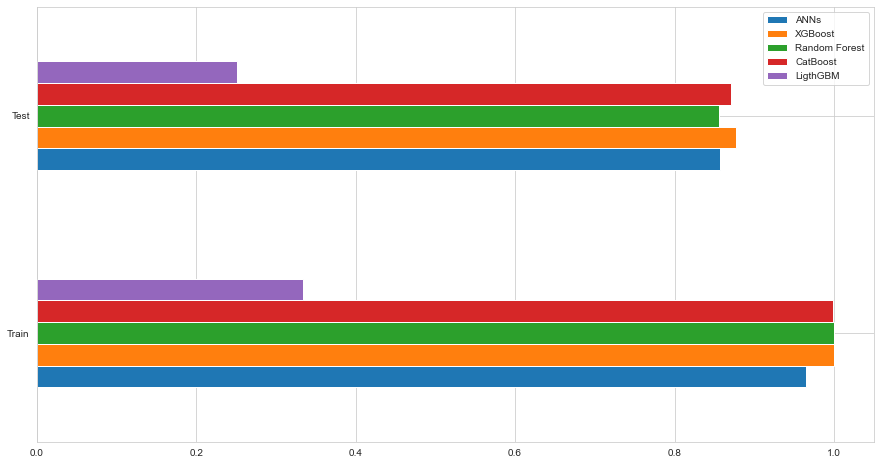

In [38]:
scores_df = pd.DataFrame(scores_dict)

scores_df.plot(kind='barh', figsize=(15, 8));

## Conclusions

We investigated the data, checking for data unbalancing, visualizing the features and understanding the relationship between different features. 
We then investigated some predictive models. The data was split in 3 parts, a train set, a validation set and a test set. For the first three models, we only used the train and test set.  

We started with **ANN**, for which we obtained an f1-score of **0.86** when predicting the target for the test set.  

We then followed with an **XGBoost**, with the f1-score of **0.88**.

We started with **RandomForrestClassifier**, for which we obtained an f1-score of **0.86** when predicting the target for the test set.  

We then followed with an **CatBoostClassifier**, with the f1-score pf **0.87**. 

We followed with an **LightGBM** model, with lower f1-score pf (**0.25**) for prediction of the test set target values.    

   
